# Preliminary steps
Connect to the drive, install tensorflow_examples and import all the necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ML_Project

/content/drive/MyDrive/ML_Project


In [3]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-dt0co_cb
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-dt0co_cb
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=639a4b0396b54ca98b28449f5d844621390e98711cac6c8713c603cee0ea5023
  Stored in directory: /tmp/pip-ephem-wheel-cache-ymgc2lxm/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [4]:
import os, sys
import time
import random
from tqdm import tqdm
from os import listdir
from PIL import Image
from IPython.display import clear_output
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt
import numpy as np

from training_utils import *
from utils import *
from resnet_utils import *
from pretrained_resnet_pytorch import *
from pretrained_resnet_tensorflow import *
from transfer_learning_utils import *

In [34]:
keras.backend.clear_session()
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
print(discriminator_x.summary())
ud = generator_g.get_layer('sequential_1')
print(ud.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, None, None, 3)]   0         
                                                                 
 sequential (Sequential)     (None, None, None, 64)    3072      
                                                                 
 sequential_1 (Sequential)   (None, None, None, 128)   131328    
                                                                 
 sequential_2 (Sequential)   (None, None, None, 256)   524800    
                                                                 
 zero_padding2d (ZeroPaddin  (None, None, None, 256)   0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 512)   2097152   
                                                             

In [31]:
keras.backend.clear_session()
generator_g = pix2pix.unet_generator(3, norm_type='instancenorm')
print(generator_g.summary())
ug = generator_g.get_layer('sequential_9')
print(ug.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, None, 64)       3072      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, None, None, 128)      131328    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, None, None, 256)      524800    ['sequential_1[0][0]']        
                                                                                              

In [24]:
keras.backend.clear_session()
gg = my_ResnetGenerator_tf()
dummy_input = np.random.randn(4, 256, 256, 3).astype(np.float32)
gg(dummy_input)
m = gg.get_layer('sequential_9')
print(m.summary())


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reflection_pad2d (Reflecti  (4, 262, 262, 3)          0         
 onPad2d)                                                        
                                                                 
 conv2d (Conv2D)             (4, 256, 256, 64)         9472      
                                                                 
 group_normalization (Group  (4, 256, 256, 64)         128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (4, 256, 256, 64)         0         
                                                                 
 conv2d_1 (Conv2D)           (4, 128, 128, 128)        73856     
                                                                 
 group_normalization_1 (Gro  (4, 128, 128, 128)       

# Preprocessing
Starting from the datasets with the extracted faces (dataset_young_faces and dataset_old_faces) we perform some pre-processing operations. In particular for the train dataset we perform:
- resizing of the image to 256x256
- random mirroring
- image normalization by applying image = (image / 127.5) - 1, so that each pixel will be between -1 and 1

The test images will be reshaped and standardized.

The preprocess_image_train and preprocess_image_test function are shown in the utils.py library.


First of all we need to load the dataset_young_faces and dataset_old_faces folders as tensorflow datasets:

In [ ]:
BATCH_SIZE = 4

In [ ]:
young_dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset_young_faces',
    labels=None,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (256, 256), #reshape if not in this size,
    seed = 17, #fix the seed to split correctly in train and test
    validation_split=0.7,
    subset='training'
)

Found 2000 files belonging to 1 classes.
Using 600 files for training.


In [ ]:
old_dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset_old_faces',
    labels=None,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (256, 256), #reshape if not in this size,
    seed = 17, #fix the seed to split correctly in train and test
    validation_split=0.7,
    subset='training'
)

Found 2000 files belonging to 1 classes.
Using 600 files for training.


Now we need to apply our preprocessing transformations to the datasets created

In [ ]:
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE

young_dataset_train = young_dataset_train.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE)

old_dataset_train = old_dataset_train.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE)

## Load a random sample_young and a random sample_old

<_ShuffleDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>
(256, 256, 3)


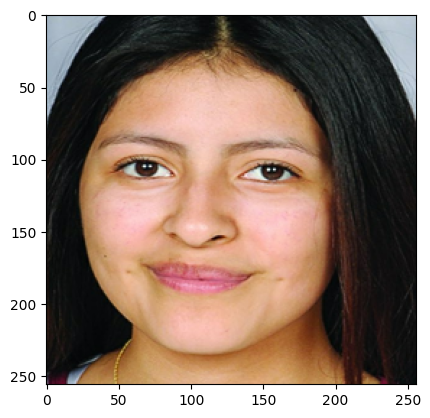

In [ ]:
# get an example from dataset_young_faces
print(young_dataset_train)
sample_young=next(iter(young_dataset_train))
print(sample_young[0].shape)
plt.imshow(sample_young[0] * 0.5 + 0.5)
# to see the image as it appears after preprocessing (without the "de-normalization") run the following:
# plt.imshow(sample_young[0])

<_ShuffleDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>
(4, 256, 256, 3)


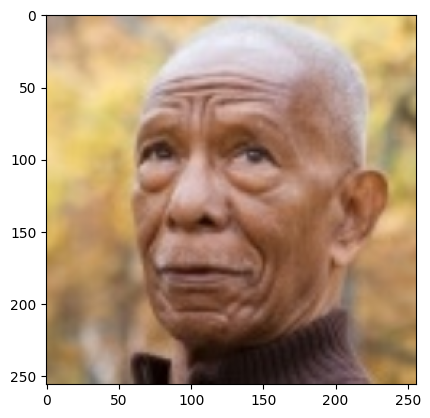

In [ ]:
# get an example from dataset_old_faces
print(old_dataset_train)
sample_old=next(iter(old_dataset_train))
print(sample_old.shape)
plt.imshow(sample_old[0] * 0.5 + 0.5)
# to see the image as it appears after preprocessing (without the "de-normalization") run the following:
# plt.imshow(sample_old[0])

# Train the Cycle-GAN using the Pix2Pix generators and discriminators

## Loading generator and discriminator from Pix2Pix
For the purpose of this experiment we use the [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py)  generators and discriminators. The model is very similar to Pix2Pix but in this case since we don't have paired images we need to use ad additional loss called **consistency loss**. In addition we use **instance normalization** instead of batch normalization and finally we use a modified **unet** generator.


The main code for this part can be found in the CycleGAN tutorial by tensorflow at [this](https://www.tensorflow.org/tutorials/generative/cyclegan) link.

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

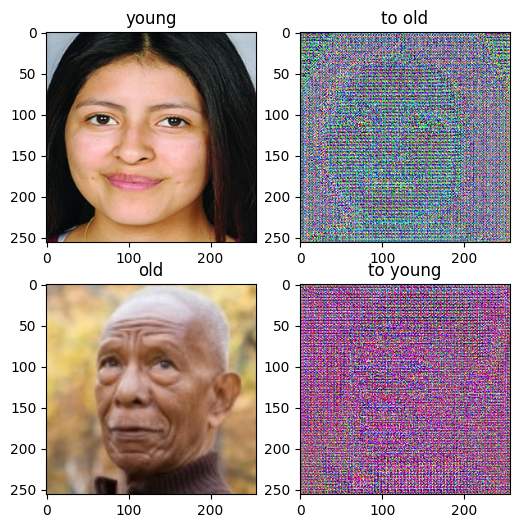

In [ ]:
# check that everything works correctly
to_old = generator_g(sample_young)
to_young = generator_f(sample_old)
plt.figure(figsize=(6,6))
contrast = 8

imgs = [sample_young, to_old, sample_old, to_young]
title = ['young', 'to old', 'old', 'to young']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

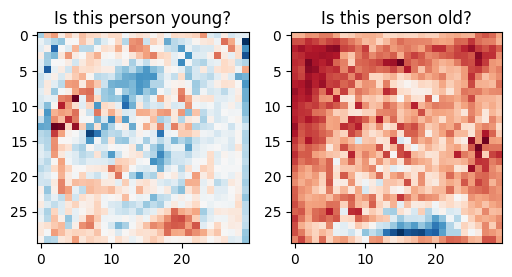

In [ ]:
plt.figure(figsize=(6, 6))

plt.subplot(121) # one line, two columns, index 1
plt.title('Is this person young?')
plt.imshow(discriminator_y(sample_young)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122) # one line, two columns, index 2
plt.title('Is this person old?')
plt.imshow(discriminator_x(sample_old)[0, ..., -1], cmap='RdBu_r')

plt.show()

# shows patch by patch if the discriminator considers the pixel young or old

## Define loss parameters and optimizers

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
generator_g_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

## Training with UNET

In [ ]:
EPOCHS = 5

In [ ]:
#checkpoints
checkpoint_path = 'checkpoints/unet_train/'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

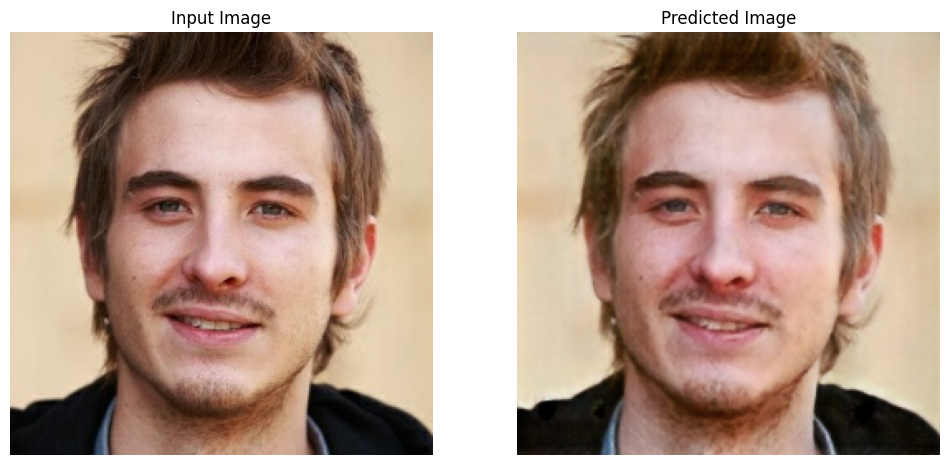

In [ ]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

for epoch in tqdm(range(EPOCHS)):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((young_dataset_train, old_dataset_train)):
    train_step(image_x, image_y,
               generator_g, generator_f,
               discriminator_x, discriminator_y,
               generator_g_optimizer, generator_f_optimizer,
               discriminator_x_optimizer, discriminator_y_optimizer,
               loss_obj, LAMBDA)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  generate_images(generator_g, sample_young)

  if (epoch + 1) % 2 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

# Coding and training a Cycle-GAN with a RESNET genarator

## Resnet Generator
To build the resnet generator we start by initializing the input tensor, perform a padding and reflect the border. This operation allows us to not risk losing relevant information from the borders of the image. Then we have the downsampling of the original image: we use a number of convolutional filters that doubles for every downsampling we decide to apply. The image will be smaller in height and width and will have increasing depth. After the downsampling of the image we apply the residual blocks and then we perform the upsampling. This last operation is specular to the upsampling one: we decrease the number of filters to apply dividing by 2 so the image will have less channels but increase height and width with the Conv2DTranspose.
Finally we apply the last padding and convolution to obtain the genarated image.

The code can be found in resnet_utils.py together with the code for the residual block.

## Define the generators and discriminators

In [ ]:
OUTPUT_CHANNELS = 3
generator_g = resnet_generator(n_residual = 6)
generator_f = resnet_generator(n_residual = 6)

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

## Define loss parameters and optimizers

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
generator_g_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

In [ ]:
#checkpoints
checkpoint_path = 'checkpoints/resnet_train/'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

## Training with the resnet generator

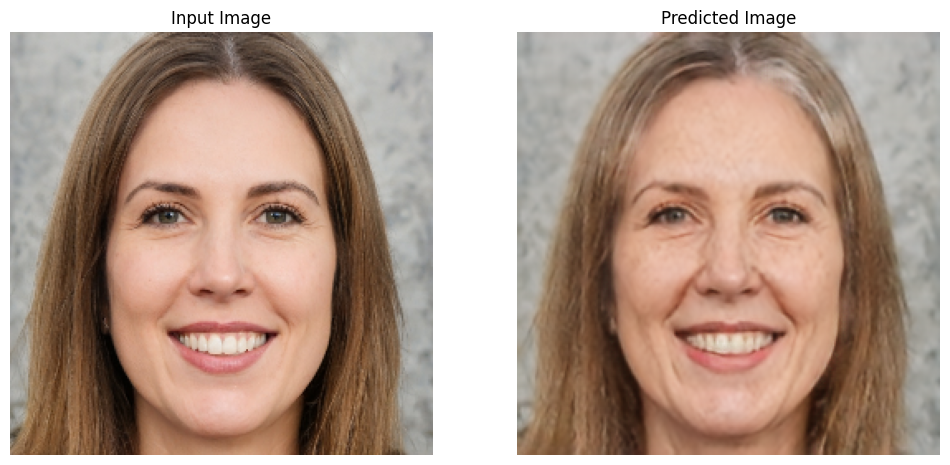

100%|██████████| 1/1 [03:56<00:00, 236.65s/it]

Saving checkpoint for epoch 1 at checkpoints/resnet_train/ckpt-77
Time taken for epoch 1 is 236.6428575515747 sec



In [ ]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

EPOCHS = 1

for epoch in tqdm(range(EPOCHS)):
  start = time.time()
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((young_dataset_train, old_dataset_train)):
    train_step(image_x, image_y,
               generator_g, generator_f,
               discriminator_x, discriminator_y,
               generator_g_optimizer, generator_f_optimizer,
               discriminator_x_optimizer, discriminator_y_optimizer,
               loss_obj, LAMBDA)

    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  generate_images(generator_g, sample_young)

  #if (epoch + 1) % 2 == 0:
  ckpt_save_path = ckpt_manager.save()
  print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

In [ ]:
# from IPython.display import Audio, display

# def beep():
#     display(Audio(filename='beep.mp3', autoplay=True))

# beep()

# Transfer Learning from horse2zebra cycle-GAN model

## From PyTorch to TensorFlow
I was only able to find the .pth pretrained model so I need to convert the model in tensorflow. The conversion using onnx was not working so I coded a resnet with the same identical structure in both pytorch and tensorflow. I loaded the weights in the pytorch model from the .pth and manually copied them in the tensorflow model. All the functions can be found in the file transfer_learning_utils.py.

In [ ]:
generator_g = get_tensorflow_model('horse2zebra_GA.pth')
generator_f = get_tensorflow_model('horse2zebra_GB.pth')

In [ ]:
# horse2zebra_GA.summary()

In [ ]:
# Freeze everything until last residual block (excluded)
# I only want to train going from the last residual block going forward
freeze_layers(horse2zebra_GA)
freeze_layers(horse2zebra_GB)

In [ ]:
# check if the correct layers are freezed

for layer in horse2zebra_GB.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

## Fine-tuning

In [ ]:
# declare generators and discriminators
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
# losses and optimizers
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_g_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

#checkpoint for the discriminator, use the trained ones from resnet_train
checkpoint_path = 'checkpoints/resnet_train/'

ckpt = tf.train.Checkpoint(discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
#checkpoints
checkpoint_path = 'checkpoints/transfer_horse2zebra/'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

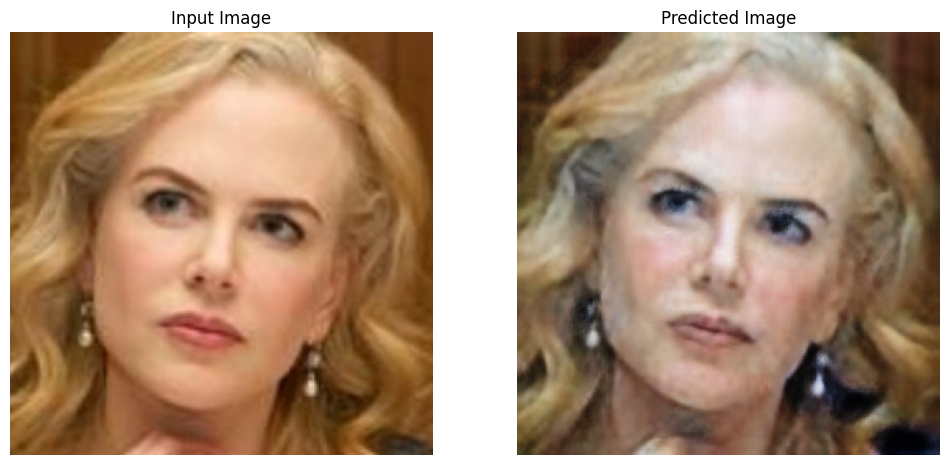

100%|██████████| 1/1 [11:26<00:00, 686.03s/it]

Saving checkpoint for epoch 1 at checkpoints/transfer_horse2zebra/ckpt-24
Time taken for epoch 1 is 686.0322604179382 sec



In [ ]:
EPOCHS = 1
for epoch in tqdm(range(EPOCHS)):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((young_dataset_train, old_dataset_train)):
    train_step(image_x, image_y,
               generator_g, generator_f,
               discriminator_x, discriminator_y,
               generator_g_optimizer, generator_f_optimizer,
               discriminator_x_optimizer, discriminator_y_optimizer,
               loss_obj, LAMBDA)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  generate_images(generator_g, sample_young)

  ckpt_save_path = ckpt_manager.save()

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

In [ ]:
# from IPython.display import Audio, display

# def beep():
#     display(Audio(filename='beep.mp3', autoplay=True))

# beep()

# Visual testing

## define test dataset

Now we show the results obtained with each technique and compare them

In [ ]:
BATCH_SIZE = 4
young_dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset_young_faces',
    labels=None,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (256, 256), #reshape if not in this size,
    seed = 17, #fix the seed to split correctly in train and test
    validation_split=0.1,
    subset='validation'
)

Found 2000 files belonging to 1 classes.
Using 200 files for validation.


In [ ]:
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE
young_dataset_test = young_dataset_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE)

In [ ]:
test_young_sample=next(iter(young_dataset_test))

## Testing the Cycle-GAN with the UNET generator

In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [ ]:
generator_g1 = pix2pix.unet_generator(3, norm_type='instancenorm')
checkpoint = tf.train.Checkpoint(generator_g=generator_g1)
checkpoint_path = 'checkpoints/unet_train/'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
generate_test_images(generator_g1, test_young_sample)

## Testing the Cycle-GAN with the RESNET generator

In [ ]:
generator_g2 = resnet_generator(n_residual = 6)
checkpoint = tf.train.Checkpoint(generator_g=generator_g2)
checkpoint_path = 'checkpoints/resnet_train/'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
generate_test_images(generator_g2, test_young_sample)

## Testing the model based on the pre-trained horse2zebra

In [ ]:
generator_g3 = get_tensorflow_model('horse2zebra_GA.pth')
checkpoint = tf.train.Checkpoint(generator_g=generator_g3)
checkpoint_path = 'checkpoints/transfer_horse2zebra/'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
generate_test_images(generator_g3, test_young_sample)

## Compare the models


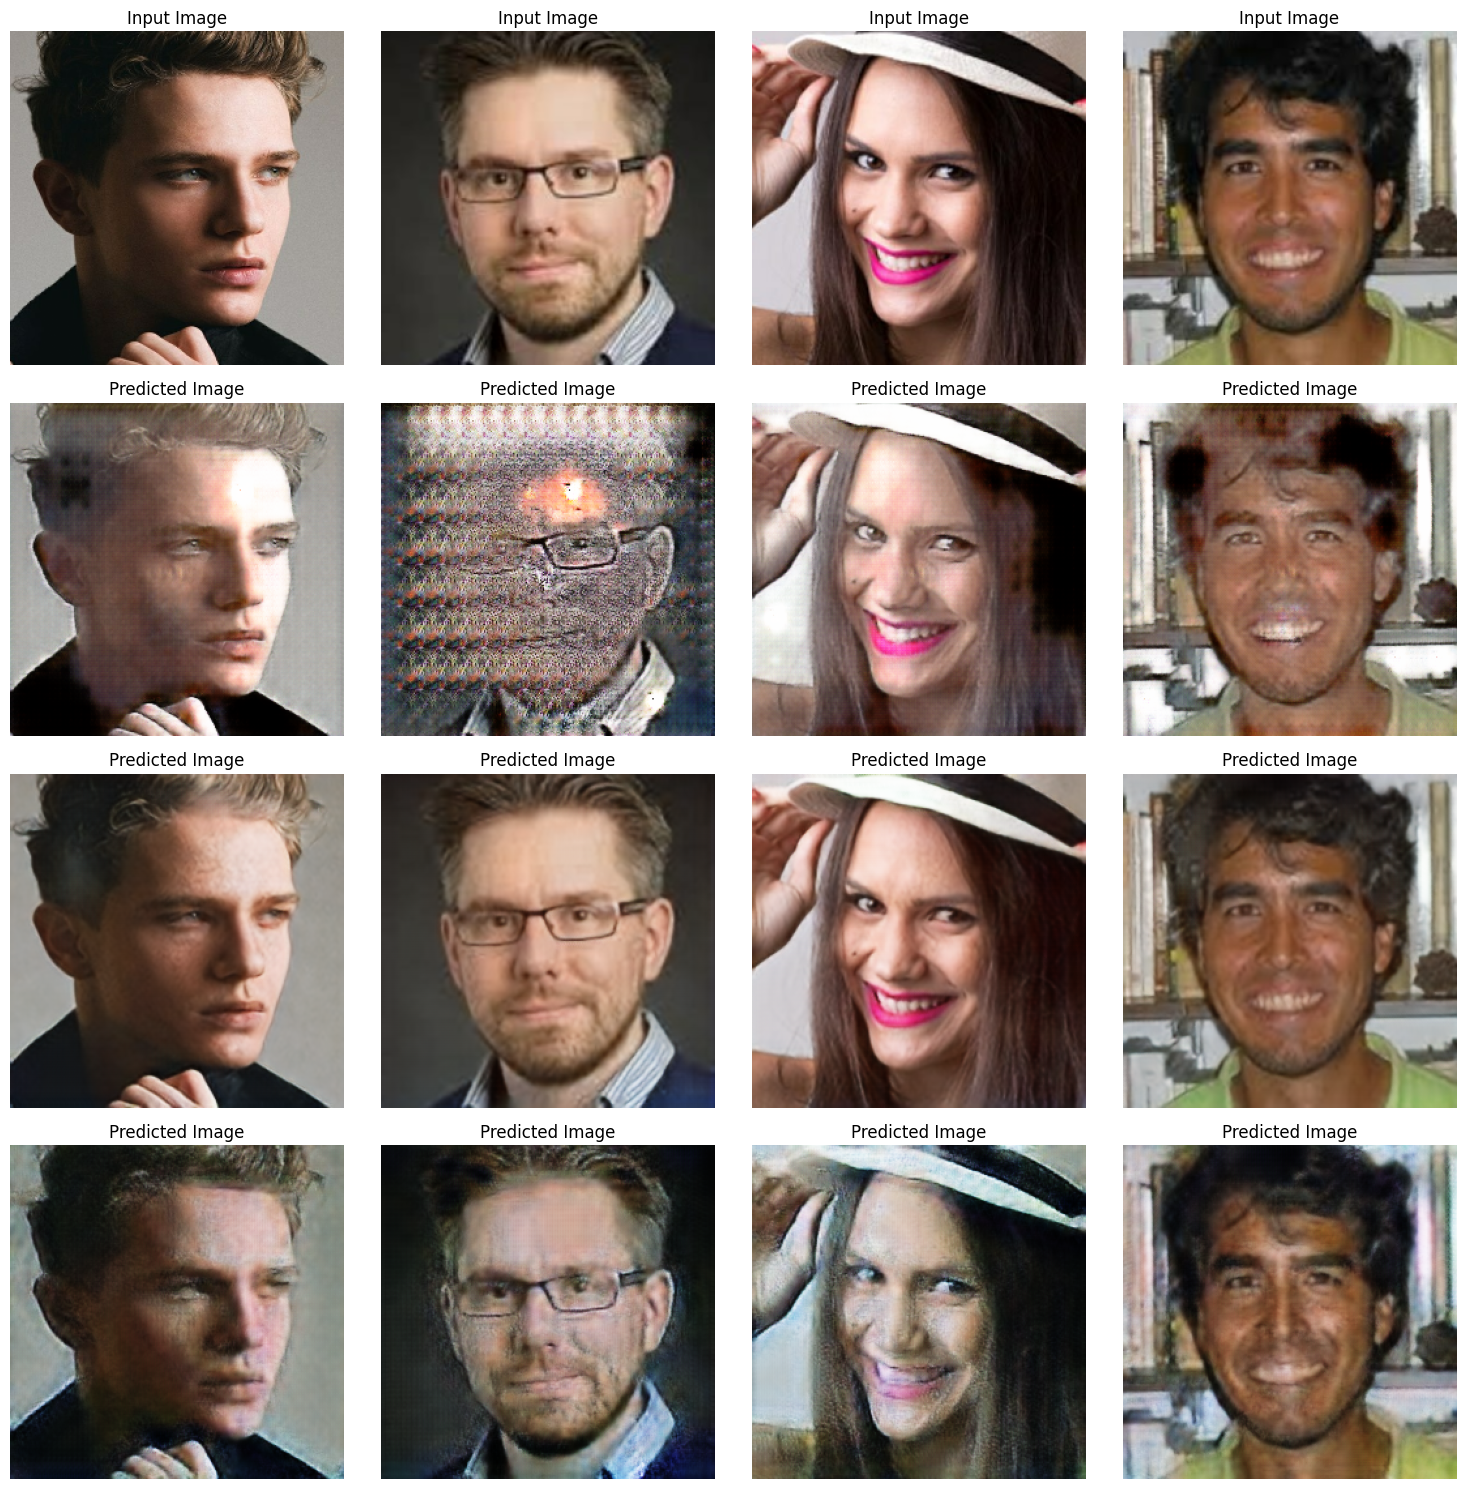

In [ ]:
compare_models(generator_g1, generator_g2, generator_g3, test_young_sample)

# Evalutation with age detection
To evaluate the performances of our models in a more quantitative way, we import the age and gender detection of the DeepFace library. Using this tool we compare the ages of the people in the images before and after going through our models.

## Requirements

In [ ]:
pip install deepface

In [ ]:
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt
from PIL import Image

24-02-22 23:39:19 - Directory /root/.deepface created
24-02-22 23:39:19 - Directory /root/.deepface/weights created


In [ ]:
BATCH_SIZE = 4
young_dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset_young_faces',
    labels=None,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (256, 256), #reshape if not in this size,
    seed = 17, #fix the seed to split correctly in train and test
    validation_split=0.1,
    subset='validation'
)

Found 2000 files belonging to 1 classes.
Using 200 files for validation.


In [ ]:
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE
young_dataset_test = young_dataset_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE)

In [ ]:
def evaluate_age_difference(young_dataset_test, model):
  original_ages = []
  generated_ages = []

  for batch in young_dataset_test:
    # find the ages of the people in each batch
    for image in batch:
      image_np = np.array(image)
      im = np.uint8((image_np+1)*127.5) #rescale the image in the range 0-255
      result = DeepFace.analyze(im, actions=['age'], enforce_detection=False)

      original_ages.append(result[0]['age'])

    # pass the batch through the aging model
    generated_batch = model(batch)

    # find the ages of the people in the generated images
    for image in generated_batch:
      image_np = np.array(image)
      im = np.uint8((image_np+1)*127.5) #rescale the image in the range 0-255
      result = DeepFace.analyze(im, actions=['age'], enforce_detection=False)

      generated_ages.append(result[0]['age'])

  # compute the age difference between images before and after aging
  age_difference = np.array([age2-age1 for age1,age2 in zip(original_ages, generated_ages)])

  return age_difference

## Evaluate the Cycle-GAN with UNET generator

In [ ]:
generator_g = pix2pix.unet_generator(3, norm_type='instancenorm')
checkpoint = tf.train.Checkpoint(generator_g=generator_g)
checkpoint_path = 'checkpoints/unet_train/'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [ ]:
age_difference = evaluate_age_difference(young_dataset_test, generator_g)

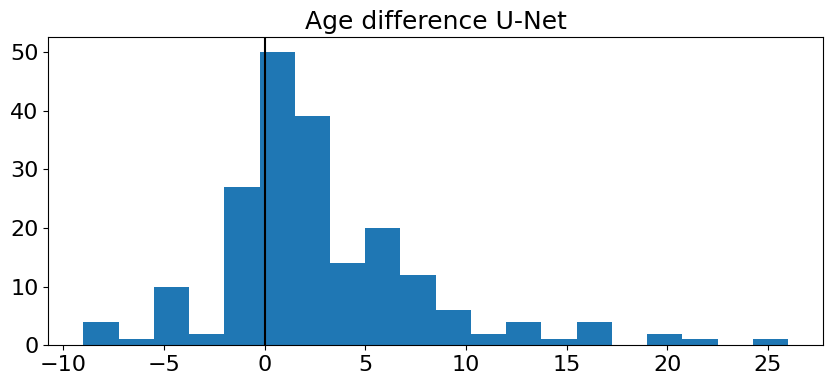

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(age_difference, bins=20)
plt.axvline(x=0, color='black')
plt.title('Age difference U-Net', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('age_diff_unet.pdf')
plt.show()

In [ ]:
# find the % of people that deepface considers aged
aged_people = age_difference[age_difference>0].shape[0]*100/age_difference.shape[0]

# find the % of people aged more than 5 years
aged_people5 = age_difference[age_difference>5].shape[0]*100/age_difference.shape[0]

# find the % of people aged more than 10 years
aged_people10 = age_difference[age_difference>10].shape[0]*100/age_difference.shape[0]

In [ ]:
print(aged_people)
print(aged_people5)
print(aged_people10)

60.5
20.5
7.5


## Evaluate the Cycle-GAN with ResNet generator

In [ ]:
generator_g = resnet_generator(n_residual = 6)
checkpoint = tf.train.Checkpoint(generator_g=generator_g)
checkpoint_path = 'checkpoints/resnet_train/'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
age_difference = evaluate_age_difference(young_dataset_test, generator_g)

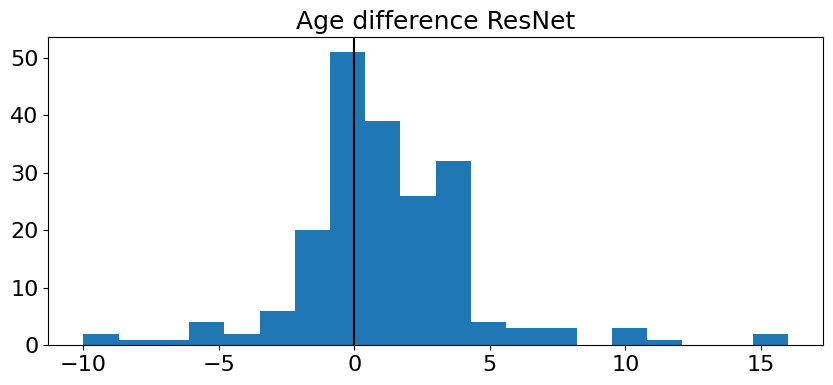

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(age_difference, bins=20)
plt.axvline(x=0, color='black')
plt.title('Age difference ResNet', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('age_diff_resnet.pdf')
plt.show()

In [ ]:
# find the % of people that deepface considers aged
aged_people = age_difference[age_difference>0].shape[0]*100/age_difference.shape[0]

# find the % of people aged more than 5 years
aged_people5 = age_difference[age_difference>5].shape[0]*100/age_difference.shape[0]

# find the % of people aged more than 10 years
aged_people10 = age_difference[age_difference>10].shape[0]*100/age_difference.shape[0]

In [ ]:
print(aged_people)
print(aged_people5)
print(aged_people10)

56.5
6.0
1.5


## Evaluate the model based on the pre-trained horse2zebra

In [ ]:
generator_g = get_tensorflow_model('horse2zebra_GA.pth')
checkpoint = tf.train.Checkpoint(generator_g=generator_g)
checkpoint_path = 'checkpoints/transfer_horse2zebra/'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
age_difference = evaluate_age_difference(young_dataset_test, generator_g)

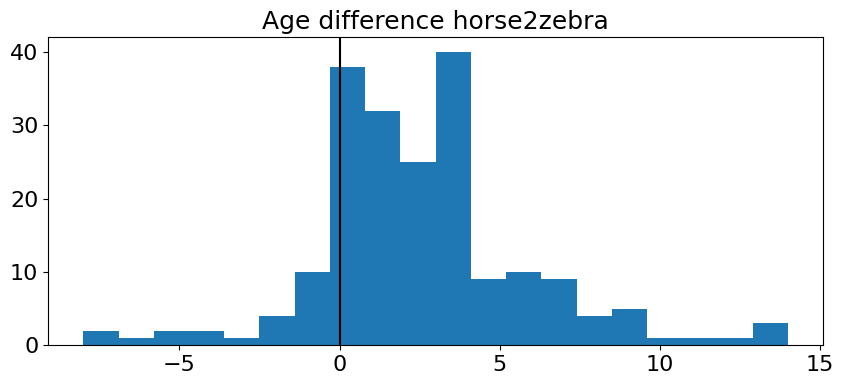

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(age_difference, bins=20)
plt.axvline(x=0, color='black')
plt.title('Age difference horse2zebra', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('age_diff_horse2zebra.pdf')
plt.show()

In [ ]:
# find the % of people that deepface considers aged
aged_people = age_difference[age_difference>0].shape[0]*100/age_difference.shape[0]

# find the % of people aged more than 5 years
aged_people5 = age_difference[age_difference>5].shape[0]*100/age_difference.shape[0]

# find the % of people aged more than 10 years
aged_people10 = age_difference[age_difference>10].shape[0]*100/age_difference.shape[0]

In [ ]:
print(aged_people)
print(aged_people5)
print(aged_people10)

70.0
17.0
2.5
